#### ASTR 3890 - Selected Topics: Data Science for Large Astronomical Surveys (Spring 2022)
***N. Hernitschek***
___

# Final Exam
### Due: Monday, May 2nd at 4.00pm CST


---

## Problem 1

A model with 10 parameters describes the statistics of the temperature fluctuations
of the Cosmic Microwave Background. We fit this model to 45 published data points of the
variance of the fluctuations as a function of angular scale and find χ2 = 52.7. We then set 5
of the model parameters to zero and fit the model again, this time getting χ2 = 54. Were we
justified in using all 10 parameters in the model?


### Solution

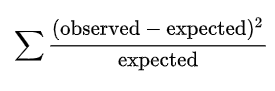

Source: “Minimum Chi-Square Estimation.” Wikipedia, 17 Apr. 2020. Wikipedia, https://en.wikipedia.org/w/index.php?title=Minimum_chi-square_estimation&oldid=951476166.

In [1]:
from scipy import stats
print("10 param χ2:", 52.7/45, "\n10 param approximate obs/exp:",round(((52.7/45)**.5-1)*100,2),"% \nχ2 CDF:",stats.chi2.cdf(52.7, 45-10))
print("\n")
print("5 param χ2:", 54/45, "\n5 param approximate obs/exp:",round(((54/45)**.5-1)*100,2),"% \nχ2 CDF:",stats.chi2.cdf(54, 45-5))

10 param χ2: 1.1711111111111112 
10 param approximate obs/exp: 8.22 % 
χ2 CDF: 0.9722008030177426


5 param χ2: 1.2 
5 param approximate obs/exp: 9.54 % 
χ2 CDF: 0.9312807114333576


We are probably not justified in using 10 parameters because the additional 5 parameters drops the average χ2 for each data point from 1.2 to 1.17. This equates to the 10 param model being off by roughly 8.22% and the 5 param model being off by roughly 9.54%. In most cases, that would be an insiginificant difference. We can additionally consider this relative to the chi-squared distribution. The 5 parameter model is closer to the median, meaning it is closer to a perfect model if you account for degrees of freedom. The 5 parameter model is also better because there would be an additional cost of monitoring/storing the extra data. Furthermore, there is a possibility that the model will lose generalizability/robustness if it is overfit with more parameters than is reasonable.

## Problem 2

Explain what Malmquist bias is. Use the Malmquist bias to explain how it can fool the unwary astronomer into thinking that stellar or galaxy luminosities measured at different wavelengths can appear correlated, even if there is no true correlation.

### Solution

Astronomical data largerly comes from light. The intensity is equal to $\frac{constant}{radius^2}$. At some point, the intensity will decay to levels that increasingly difficult to detect. At large distances, equipment will only be able to detect the brightest stars. Therefore, there will be a bias in astronmical data in favor of bright stars at large distances. 

This leads to a correlation between distance and luminosity where you know the greater the distance, the greater the minimum luminosity. If the wavelength is correlated with distance, then astronomers unaware of the bias will believe wavelength is directly correlated with luminosity.

## Problem 3

1) Read in final_data_3.npy. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

3) Compute and plot the Bayesian posterior probability density (not the log posterior) for the mean voltage assuming a uniform prior for the mean in the range 3 to 7. Make sure this posterior pdf is normalized.

4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to the sample mean plus/minus the standard error, respectively. Also find the MAP value of the mean.
*mean average precision

### Solution

In [19]:
import requests
import io
import numpy as np
import pickle
import pandas as pd
from scipy import optimize
from scipy.stats import norm
import scipy
import pymc3 as pm
from pymc3 import Normal, sample
from scipy.stats import uniform
from scipy import stats
from matplotlib import pyplot as plt

In [3]:
#1. 
data = np.load('final_data_3.npy')
print(data)

[[4.36 2.24]
 [4.   1.94]
 [4.87 1.39]
 [5.64 2.55]
 [6.14 1.69]
 [5.92 1.38]
 [3.93 1.  ]
 [6.58 1.6 ]
 [3.78 1.  ]
 [5.84 1.  ]]


In [4]:
mean_orig = np.mean(data[:,0])
stdev_orig = np.std(data[:,0], ddof=1)
SE_orig = stdev_orig / np.sqrt(np.size(data[:,0])) 
print("The mean is", mean_orig,"\nThe standard deviation is", stdev_orig, "\nThe standard error of the mean is", SE_orig)

The mean is 5.106 
The standard deviation is 1.038430439547001 
The standard error of the mean is 0.32838053806183115


Optimization terminated successfully.
         Current function value: 14.039687
         Iterations: 46
         Function evaluations: 90
The mean is 5.106043791197767 
The standard deviation is 0.9851230180230219 
The standard error of the mean is 0.3115232512411854


Text(0.5, 1.0, 'Comparison of data and uncertainties to gauss log likelihood mean')

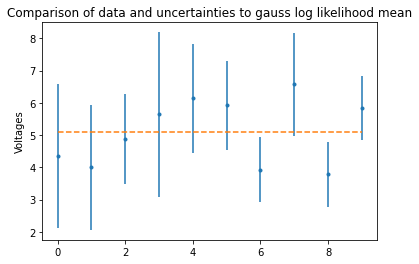

In [5]:
#2.
#Assume gaussian distribution
theta_guess = [1,5]
xi = data[:,0]
def gauss_logL(theta):
    mu = theta[0]
    sigma = theta[1]
    logLs = scipy.stats.norm.logpdf(x=xi, loc=mu, scale=sigma)
    return -np.sum(logLs) #Negative for minimization
    
#Optimize log likelihood
theta_est = optimize.fmin(gauss_logL, theta_guess)
mean_logL = theta_est[0]
stdev_logL = theta_est[1]
SE_logL = stdev_logL / np.sqrt(np.size(data[:,0])) 
print("The mean is", mean_logL,"\nThe standard deviation is", stdev_logL, "\nThe standard error of the mean is", SE_logL)

#Plot to see fit
x = np.arange(len(data))
plt.errorbar(x, data[:,0],data[:,1],fmt='.')
plt.plot([min(x),max(x)], [mean_logL,mean_logL],'--')
plt.ylabel("Voltages")
plt.title("Comparison of data and uncertainties to gauss log likelihood mean")

In [6]:
#3.
with pm.Model() as model:  # model specifications in PyMC3 are wrapped in a with-statement
    #Define priors
    mu = uniform.stats(loc=3, scale=7)

    #Define likelihood
    likelihood = Normal("y", mu=mean_orig, sigma=stdev_orig)

    #Inference
    #Draw posterior samples using NUTS sampling
    trace = sample(1000, return_inferencedata=True)
    
print("Done")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\jtsen\AppData\Local\Programs\Python\Python310\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\jtsen\AppData\Local\Programs\Python\Python310\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 71 seconds.


Done


The mean is 5.049297187730528 
The standard deviation is 1.0382851599689078 
The standard error of the mean is 0.3283345966254029


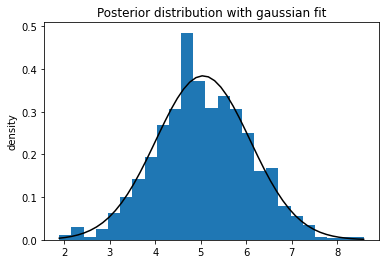

In [7]:
dist = trace.posterior.y[0]

elem = plt.hist(dist,bins=25,density=True)

#Plot a fitted Gaussian
F_fit = np.linspace(min(dist),max(dist))
mean_post=np.mean(dist).values
stdev_post=np.std(dist, ddof=1).values
distribution = stats.norm(mean_post,stdev_post)
pdf = distribution.pdf(F_fit)
plt.plot(F_fit, pdf, '-k')
plt.ylabel("density")
plt.title("Posterior distribution with gaussian fit")
SE_post = stdev_post / np.sqrt(np.size(data[:,0])) 
print("The mean is", mean_post,"\nThe standard deviation is", stdev_post, "\nThe standard error of the mean is", SE_post)

In [8]:
#4.
lower_percentile = (100-68.3)/2
upper_percentile = 100 - lower_percentile
lower = np.percentile(dist,lower_percentile)
upper = np.percentile(dist,upper_percentile) 
print("Lower bound:",lower)
print("Upper bound:",upper)
print(xi)

Lower bound: 4.0374961002744705
Upper bound: 6.086358615060228
[4.36 4.   4.87 5.64 6.14 5.92 3.93 6.58 3.78 5.84]


Just about all of the points are contained in the range so it looks reasonable.

In [9]:
print("Standard error range:", mean_orig-SE_orig,"to",mean_orig+SE_orig)
print("One standard deviation range:", mean_orig-stdev_orig,"to",mean_orig+stdev_orig)
print("Maximum a posteriori given by the trace samples is:", elem[1][np.argmax(elem[0])])

Standard error range: 4.777619461938169 to 5.434380538061831
One standard deviation range: 4.0675695604529984 to 6.144430439547001
Maximum a posteriori given by the trace samples is: 4.565953588330387


The standard error range is tighter than middle 68.3%. However the the range of +/- one standard deviation is very close to the middle 68.3% as expected. The histogram peak put the MAP at about 4.57.

## Problem 4

This problem has to do with dimensional reduction. We're going to load in a sample of SDSS Imaging data.

1. Execute the cell below to read in the data, print out the feature names, and create a data matrix out of a subset of features.


In [10]:
from astroML.datasets import fetch_imaging_sample
data = fetch_imaging_sample()  
data.shape  # number of objects in dataset

print(data.dtype.names)

keylist = ['ra', 'dec', 'rExtSFD', 'uRaw', 
           'gRaw', 'rRaw', 'iRaw', 'zRaw', 
           'uErr', 'gErr', 'rErr', 'iErr', 
           'zErr', 'uRawPSF', 'gRawPSF', 
           'rRawPSF', 'iRawPSF', 'zRawPSF', 
           'upsfErr', 'gpsfErr', 'rpsfErr', 
           'ipsfErr', 'zpsfErr']

X = np.column_stack([data[key] for key in keylist]) 

('ra', 'dec', 'run', 'rExtSFD', 'uRaw', 'gRaw', 'rRaw', 'iRaw', 'zRaw', 'uErr', 'gErr', 'rErr', 'iErr', 'zErr', 'uRawPSF', 'gRawPSF', 'rRawPSF', 'iRawPSF', 'zRawPSF', 'upsfErr', 'gpsfErr', 'rpsfErr', 'ipsfErr', 'zpsfErr', 'type', 'ISOLATED')


2. Use PCA (with randomized svd_solver for speed if necessary) to reduce the data matrix down to features. What is the explained variance of the data encapsulated in these eigen-features?

3. 
    Access the `type` key of the `data` structure and make an array of labels out of these. Do some research in astroML documentation to find out what these integer types correspond to, and state that here.

4. Choose 5000 random integers between 0 and the number of samples in the data matrix. Record these integers because you'll use them later. Make a scatter plot of the PCA-reduced data for these 5000 random samples, colored by their corresponding type. (You may want to set the transparency to be lower than 1 to see the mixing of samples.)


5.  Now try some non-linear dimensional reduction. These algorithms are slower than PCA, so you will operate only on the 5000 random samples identified in the previous part.

* Try LocallyLinearEmbedding, Isomap, and TSNE algorithms, setting the number of components to be 2 in all cases.
* As in the PCA case, make scatter plots of the dimensionally-reduced data, color coded by their type. For LLE and Isomap, experiment with the number of nearest neighbors between 5 and 100 to see what visually gives the best separation in type populations. For TSNE, do the same for the perplexity attribute.
* Which algorithm gives the cleanest way to visually see the two populations of sources? (This will be subjective according to the samples you trained on, and even the randomness of the algorithms.)




### Solution

In [11]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import random
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
import sklearn.metrics

In [12]:
#2.
n_components = X.shape[1]
features = 2
pca = PCA(features, svd_solver='randomized')
pca.fit(X)
evals = pca.explained_variance_ratio_ 

print("Variance explained by eigen-feature 1:",round(evals[0]*100,1),"%\nVariance explained by eigen feature-2:",round(evals[1]*100,1),"%")

Variance explained by eigen-feature 1: 53.3 %
Variance explained by eigen feature-2: 25.0 %


In [13]:
#3.
print(np.unique(data['type']))

[3 6]


The only possible types in this dataset are 3 or 6.
Type 3 is resolved sources (mostly galaxies).
Type 6 is unresolved sources (mostly stars and quasars) 

Text(0, 0.5, 'Feature 2')

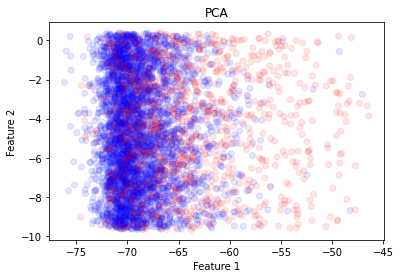

In [14]:
#4.
data_len = len(data['type'])
nums = random.sample(range(data_len), 5000)
id_color = {3: u'blue', 6: u'red'}
color_map = [id_color[i] for i in data['type'][nums]]

X_PCA = np.matmul(X[nums,:],np.transpose(pca.components_))

plt.scatter(X_PCA[:, 0], X_PCA[:, 1],c=color_map, alpha=0.1)
plt.title("PCA")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

Text(0, 0.5, 'Feature 2')

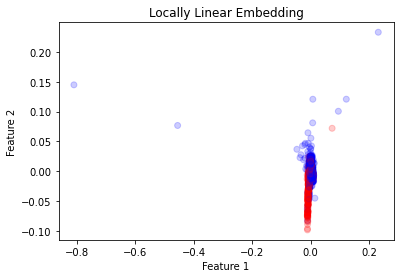

In [22]:
#5.
#LocallyLinearEmbedding
embedding = LocallyLinearEmbedding(n_components=2,n_neighbors=10)
X_LLE = embedding.fit_transform(X[nums,:])
plt.scatter(X_LLE[:,0],X_LLE[:,1],c=color_map, alpha=0.2)
plt.title("Locally Linear Embedding")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

Text(0, 0.5, 'Feature 2')

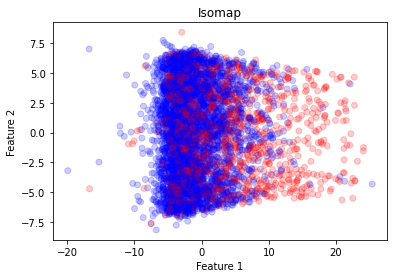

In [23]:
#Isomap
embedding = Isomap(n_components=2,n_neighbors=20)
X_Isomap = embedding.fit_transform(X[nums,:])
plt.scatter(X_Isomap[:,0],X_Isomap[:,1],c=color_map, alpha=0.2)
plt.title("Isomap")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

Text(0, 0.5, 'Feature 2')

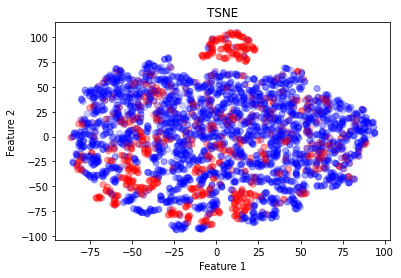

In [20]:
#TSNE
embedding = TSNE(n_components=2,learning_rate='auto', init='random',perplexity=10)
X_TSNE = embedding.fit_transform(X[nums,:])
plt.scatter(X_TSNE[:,0],X_TSNE[:,1],c=color_map, alpha=0.2)
plt.title("TSNE")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")

In [24]:
#Measuring seperation with silhouette score
scorePCA = sklearn.metrics.silhouette_score(X_PCA, data['type'][nums])
scoreLLE = sklearn.metrics.silhouette_score(X_LLE, data['type'][nums])
scoreIsomap = sklearn.metrics.silhouette_score(X_Isomap, data['type'][nums])
scoreTSNE = sklearn.metrics.silhouette_score(X_TSNE, data['type'][nums])
print("PCA:",scorePCA,"\nLocally Linear Embedding:",scoreLLE,"\nIsomap:",scoreIsomap,"\nTSNE:",scoreTSNE)

PCA: 0.18627551602121006 
Locally Linear Embedding: 0.2048929471795662 
Isomap: 0.16496445411685254 
TSNE: 0.042985678


Generally, the cleanest way to see the visual representation of the the two populations is when you have the greatest separation between the populations. According to the silhouette score, the cleanest separation comes from the locally linear embedding algorithim. This isn't exact though because the performance depends on that particular random run and the particular number of clusters used.